In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as stats

from skimage import io, filters, color,exposure,feature,measure,segmentation
from scipy import ndimage
import cv2 
import imutils

In [2]:
image = plt.imread('../data/test.bmp')

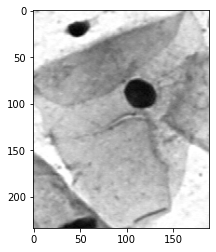

In [3]:
# convert to grayscale
gray_img = color.rgb2gray(image)
plt.imshow(gray_img,cmap='gray')

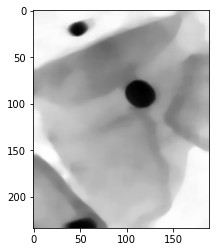

In [5]:
# apply median filter
filt_gray = ndimage.median_filter(gray_img,15)
# filt_gray = cv2.medianBlur(gray_img,5)
plt.imshow(filt_gray,cmap='gray')

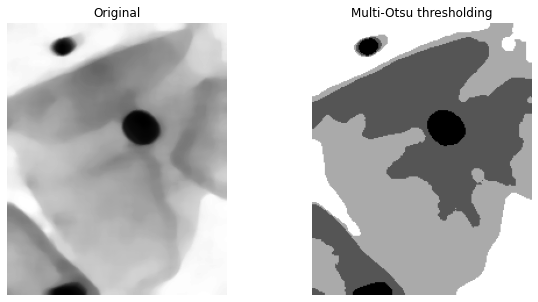

In [6]:
thresholds = filters.threshold_multiotsu(filt_gray, classes=4)
regions = np.digitize(filt_gray, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(filt_gray,cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions,cmap='gray')
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()

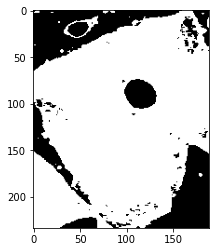

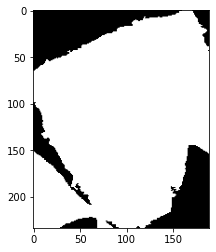

In [8]:
## cyto segmentation

# create binary image
threshold = filters.threshold_minimum(gray_img)
cyto = (gray_img > thresholds[0]) & (gray_img < thresholds[2])
plt.imshow(cyto, cmap=plt.cm.gray)
plt.show()

# find contours
cnts = cv2.findContours(cyto.astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
outline = np.zeros(cyto.shape,dtype='uint8')
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
cyto = cv2.drawContours(outline, [cnts], -1, 1, -1)
plt.imshow(cyto,cmap='gray')
plt.show()


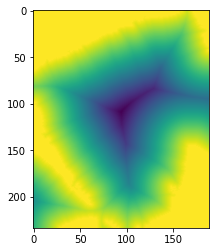

In [9]:
# watershed algorithm

# markers = cv2.watershed(cyto,nuclei.astype('uint8'))

# markers = np.zeros(cyto.shape,dtype='uint8')
# markers[nuclei_df['centroid-0'],nuclei_df['centroid-1']]=1
# labels = segmentation.watershed(cyto,markers)

distance = ndimage.distance_transform_edt(cyto)
plt.imshow(-distance)


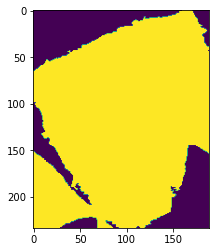

In [10]:
local_maxi = feature.peak_local_max(distance, indices=False,
                                    min_distance=7)

markers = measure.label(local_maxi)

segmented_cells = segmentation.watershed(-distance, markers, mask=cyto)

plt.imshow(segmented_cells)

In [13]:
# get a table of region properties
labeled_cells = measure.label(cyto,background=0)

props_table = measure.regionprops_table(labeled_cells,intensity_image = gray_img, properties=['area','centroid','major_axis_length','minor_axis_length','perimeter','eccentricity','solidity','max_intensity','min_intensity'])
props_table
cyto_df = pd.DataFrame.from_dict(props_table)
cyto_df

,area,centroid-0,centroid-1,major_axis_length,minor_axis_length,perimeter,eccentricity,solidity,max_intensity,min_intensity
0,34613,120,95,255.111882,181.903102,1107.70772,0.701131,0.91958,0.947857,0.265741
